# Building a Transformer from Scratch
This notebook demonstrates how to build and train a transformer model from scratch for text classification. We'll implement a simplified transformer architecture and train it on a text classification dataset to understand the key components of transformer models.

## Preparing Data for the Transformer Model

We'll first prepare our dataset for training. We'll use the IMDB dataset again, but this time we'll implement our own preprocessing to feed into our custom transformer.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Load IMDB dataset
train_ds, test_ds = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True
)

# Define vocabulary size and other parameters
VOCAB_SIZE = 15000
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32

# Create a vectorization layer to standardize, tokenize, and vectorize text
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Adapt the layer to the training dataset
train_text = train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

# Function to vectorize text and map labels
def prepare_dataset(ds):
    ds = ds.map(lambda text, label: (vectorize_layer(text), label))
    ds = ds.cache()
    ds = ds.shuffle(10000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Prepare train and test datasets
train_ds = prepare_dataset(train_ds)
test_ds = prepare_dataset(test_ds)

# Sample data to check format
for texts, labels in train_ds.take(1):
    print(f"Input shape: {texts.shape}")
    print(f"First example: {texts[0][:10]}")  # First 10 tokens of first example
    print(f"Label: {labels[0].numpy()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.5Q8QKF_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.5Q8QKF_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.5Q8QKF_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Input shape: (32, 200)
First example: [  72   90   26   11   21  700    8 1830   19   10]
Label: 0


## Building the Transformer Model

Now we'll implement a simplified transformer model architecture from scratch. The key components include token and position embeddings, multi-head attention, and feed-forward networks.

In [2]:
# Define the Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    res = keras.layers.Add()([x, inputs])

    # Feed Forward Network
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = keras.layers.Dense(ff_dim, activation="relu")(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(inputs.shape[-1])(x)
    return keras.layers.Add()([x, res])

# Build the complete model
def build_transformer_model(
    vocab_size,
    max_seq_len,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(max_seq_len,))

    # Token embeddings
    embedding_layer = keras.layers.Embedding(vocab_size, 128)
    x = embedding_layer(inputs)

    # Add positional encoding
    positions = tf.range(start=0, limit=max_seq_len, delta=1)
    position_embedding = keras.layers.Embedding(
        input_dim=max_seq_len,
        output_dim=128
    )(positions)
    x = x + position_embedding

    # Apply Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Classification head
    x = keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

# Initialize and compile the model
model = build_transformer_model(
    vocab_size=VOCAB_SIZE,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    head_size=128,
    num_heads=2,
    ff_dim=128,
    num_transformer_blocks=1,
    mlp_units=[64],
    dropout=0.1,
    mlp_dropout=0.1,
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,920,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 128)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 128)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 128)  │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 128)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_2[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,093,825 (7.99 MB)

 Trainable params: 2,093,825 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

## Training and Evaluating the Transformer Model

Let's train our transformer model and visualize its performance. We'll train for a few epochs and monitor both training and validation accuracy.

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7472 - loss: 0.4848 - val_accuracy: 0.8552 - val_loss: 0.3335
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9255 - loss: 0.1999 - val_accuracy: 0.8465 - val_loss: 0.3915
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9611 - loss: 0.1130 - val_accuracy: 0.8324 - val_loss: 0.5262
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9758 - loss: 0.0669 - val_accuracy: 0.8256 - val_loss: 0.7060


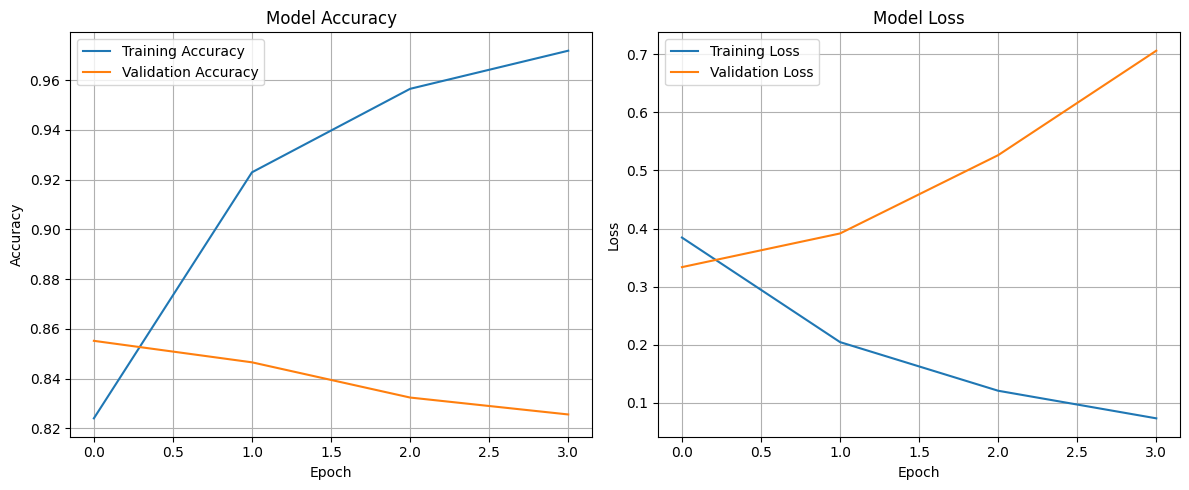

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8573 - loss: 0.3320
Test Loss: 0.3335
Test Accuracy: 0.8552


In [3]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,  # Train for just a few epochs to demonstrate
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## Testing with New Examples

Now let's test our custom transformer model with some new examples to see how well it performs on sentiment classification.

In [4]:
# Function to preprocess and predict
def predict_sentiment(texts):
    # Preprocess texts
    vectorized_texts = vectorize_layer(tf.convert_to_tensor(texts))

    # Get predictions
    predictions = model.predict(vectorized_texts)

    return predictions

# Test examples
test_texts = [
    "This movie was absolutely fantastic! One of the best I've seen this year.",
    "I hated every minute of this film. The plot made no sense and the acting was wooden.",
    "It was okay. Some parts were good but others dragged on too long.",
    "I don't have strong feelings either way about this movie."
]

# Get predictions
predictions = predict_sentiment(test_texts)

# Display results
for text, pred in zip(test_texts, predictions):
    sentiment = "Positive" if pred > 0.5 else "Negative"
    confidence = pred if pred > 0.5 else 1 - pred
    print(f"Text: {text}")
    print(f"Prediction: {sentiment} (Confidence: {confidence[0]:.4f})")
    print("-" * 70)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
Text: This movie was absolutely fantastic! One of the best I've seen this year.
Prediction: Positive (Confidence: 0.9842)
----------------------------------------------------------------------
Text: I hated every minute of this film. The plot made no sense and the acting was wooden.
Prediction: Negative (Confidence: 0.9738)
----------------------------------------------------------------------
Text: It was okay. Some parts were good but others dragged on too long.
Prediction: Negative (Confidence: 0.5990)
----------------------------------------------------------------------
Text: I don't have strong feelings either way about this movie.
Prediction: Positive (Confidence: 0.7127)
----------------------------------------------------------------------


## Understanding the Transformer Architecture

Let's examine the key components of our transformer model and how they work:

1. **Embedding Layer**: Converts token IDs to dense vectors and adds positional encoding
2. **Multi-Head Attention**: Allows the model to focus on different parts of input simultaneously
3. **Feed-Forward Network**: Processes the attention output through non-linear transformations
4. **Layer Normalization**: Stabilizes the learning process
5. **Residual Connections**: Helps with training deeper networks by providing shortcuts for gradients

The attention mechanism is what gives transformers their power, allowing them to capture long-range dependencies in text better than traditional RNNs or LSTMs.

In [5]:
# Create a simple visualization of the transformer architecture
from tensorflow.keras.utils import plot_model

# Save a visualization of the model architecture
plot_model(
    model,
    to_file='transformer_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'  # Top to bottom layout
)

print("Model architecture saved as 'transformer_model.png'")

# Display a comparison of the three approaches we've explored
print("\n=== Comparison of NLP Approaches ===")
print("\n1. Pretrained Classifier (Colab 1)")
print("   - Advantages: Fast to implement, high accuracy with no training")
print("   - Limitations: Fixed to specific tasks pretrained on")
print("\n2. Fine-tuned Model (Colab 2)")
print("   - Advantages: Leverages pretrained knowledge, adapts to specific tasks")
print("   - Limitations: Requires some training data and fine-tuning time")
print("\n3. Custom Transformer (Colab 3)")
print("   - Advantages: Complete flexibility, educational to understand architecture")
print("   - Limitations: Requires more training data, more time to train")
print("\nRecommendation for production: Start with pretrained models and fine-tune, ")
print("only building custom architectures when specific requirements aren't met by existing models.")

Model architecture saved as 'transformer_model.png'

=== Comparison of NLP Approaches ===

1. Pretrained Classifier (Colab 1)
   - Advantages: Fast to implement, high accuracy with no training
   - Limitations: Fixed to specific tasks pretrained on

2. Fine-tuned Model (Colab 2)
   - Advantages: Leverages pretrained knowledge, adapts to specific tasks
   - Limitations: Requires some training data and fine-tuning time

3. Custom Transformer (Colab 3)
   - Advantages: Complete flexibility, educational to understand architecture
   - Limitations: Requires more training data, more time to train

Recommendation for production: Start with pretrained models and fine-tune, 
only building custom architectures when specific requirements aren't met by existing models.
